# Testing pyarrow & pandas

In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.plasma as plasma
import timeit
import matplotlib.pyplot as plt

import os
import psutil
process = psutil.Process(os.getpid())

## Notes

La doc: https://arrow.apache.org/docs/python/plasma.html#starting-the-plasma-store

### Le Plasma Store

* Ne fonctionne que sur _Linux_ et _MacOS_
* Le processus pour faire passer un objet python au Plasma Store:
  * Transformer l'objet python en objet Arrow                     - Duplication de la mémoire en RAM
  * Créer un emplacement avec un ID et la bonne taille allouée    - On alloue la mémoire dans le plasma store
  * Ecrire l'objet dans cet emplacement                           - On écrit dans le plasma store
* Le processus pour lire depuis le Plasma Store
  * On ouvre un buffer vers l'emplacement où on a écrit l'objet   - Il nous faut l'ID de l'objet qu'on lit
  * On lit depuis le buffer pour avoir un objet Arrow             - On n'alloue pas la mémoire dans le process python
  * On transforme l'objet Arrow en objet python                   - Ici on alloue la mémoire au process python

## Comparaison dump .csv VS ecriture plasma store

In [2]:
client = plasma.connect("/tmp/plasma")
data = pd.read_csv('./data/test_data.csv')

csv_memory = []
plasma_memory = []

In [3]:
def dump_and_read_csv(df):
    rss1 = process.memory_info().rss/1048576 - current_rss
    df.to_csv('/tmp/csv.csv')
    initial_data = pd.read_csv('/tmp/csv.csv')
    rss2 = process.memory_info().rss/1048576 - current_rss
    csv_memory.append((rss1+rss2)/2)
    return initial_data

In [4]:
object_id = plasma.ObjectID(np.random.bytes(20))

def dump_to_plasma(df):
    record_batch = pa.RecordBatch.from_pandas(df)
    mock_sink = pa.MockOutputStream()
    stream_writer = pa.RecordBatchStreamWriter(mock_sink, record_batch.schema)
    stream_writer.write_batch(record_batch)
    stream_writer.close()
    data_size = mock_sink.size()
    buf = client.create(object_id, data_size)
    
    # Write the PyArrow RecordBatch to Plasma
    stream = pa.FixedSizeBufferWriter(buf)
    stream_writer = pa.RecordBatchStreamWriter(stream, record_batch.schema)
    stream_writer.write_batch(record_batch)
    stream_writer.close()
    # Seal the Plasma object
    client.seal(object_id)
    return object_id

def read_from_plasma(object_id):
    # Fetch the Plasma object
    [data] = client.get_buffers([object_id])  # Get PlasmaBuffer from ObjectID
    buffer = pa.BufferReader(data)
    iiio = pa.input_stream(buffer)
    # Convert object back into an Arrow RecordBatch
    reader = pa.RecordBatchStreamReader(buffer)
    record_batch = reader.read_next_batch()
    return record_batch.to_pandas()

def dump_and_read_plasma(df):
    rss1 = process.memory_info().rss/1048576 - current_rss
    object_id = dump_to_plasma(df)
    initial_data = read_from_plasma(object_id)
    rss2 = process.memory_info().rss/1048576 - current_rss
    client.delete([object_id])
    rss3 = process.memory_info().rss/1048576 - current_rss
    plasma_memory.append((rss1 + rss2 + rss3)/3)
    return initial_data


In [5]:
def wrapper(func, *args, **kwargs):                                                                   
    def wrapper():                                                                                    
        return func(*args, **kwargs)                                                                  
    return wrapper 

nb_measures = 50;

Dump and read pandas Dataframe to .csv takes 576.8746936399839 milliseconds


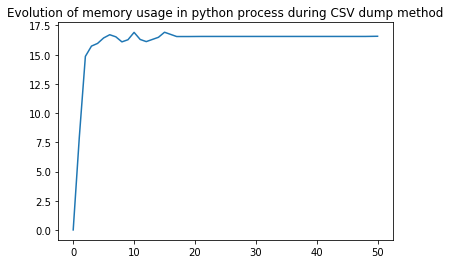

In [6]:
csv_memory = []
current_rss = process.memory_info().rss/1048576
rss = process.memory_info().rss/1048576 - current_rss
csv_memory.append(rss)

csv_timer = timeit.timeit(wrapper(dump_and_read_csv, data), number=nb_measures)
print("Dump and read pandas Dataframe to .csv takes {} milliseconds".format(csv_timer*1000/nb_measures))
plt.plot(csv_memory)
plt.title("Evolution of memory usage in python process during CSV dump method")
plt.show()

Dump and read pandas Dataframe to plasma store takes 103.23198541998863 milliseconds


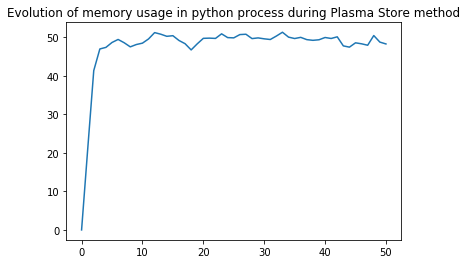

In [7]:
plasma_memory = []
current_rss = process.memory_info().rss/1048576
rss = process.memory_info().rss/1048576 - current_rss
plasma_memory.append(rss)

plasma_timer = timeit.timeit(wrapper(dump_and_read_plasma, data), number=nb_measures)
print("Dump and read pandas Dataframe to plasma store takes {} milliseconds".format(plasma_timer*1000/nb_measures))

plt.plot(plasma_memory)
plt.title("Evolution of memory usage in python process during Plasma Store method")
plt.show()